# 시계열 예측 - clogging


In [18]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## clogging data

```
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)
```

In [19]:
import os
import mglearn

df = pd.read_csv(
    os.path.join(mglearn.datasets.DATA_PATH, "constant_trial.csv") )

# 예제를 위해 몇개의 열만 선택합니다
#df = df[['IR', 'FlowHt', 'Const', 'Var', 'Base', 'MixS75','MixS50','MixS25']]
df = df[['IR', 'FlowHt', 'Base', 'MixS75','MixS50','MixS25']]
display(df.head())


,IR,FlowHt,Base,MixS75,MixS50,MixS25
0,1.0000,0.0000,1,0,0,0
1,0.9995,0.1798,1,0,0,0
2,0.9985,0.5389,1,0,0,0
3,0.9970,1.0757,1,0,0,0
4,0.9950,1.7884,1,0,0,0


```
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
Oneencoder = OneHotEncoder(categorical_features=[0])
#df[:,4] = encoder.fit_transform(df[:,4])

df[:,4] = Oneencoder.fit_transform(df[:,4])
```

In [20]:
# 검사 및 정리하기

### 데이터 분할

column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
#train_df = df[0:int(n*0.7)]
train_df = df[0:int(n*0.5)].copy()
test_df = df[int(n*0.5):int(n*0.75)].copy()
val_df = df[int(n*0.75):].copy()

num_features = df.shape[1]
num_features


train_df.describe()

train_mean = train_df.mean()
train_std = train_df.std()

In [21]:
# ## 데이터 정규화

train_mean = train_df.mean()
train_std = train_df.std()

train_df.iloc[:,:2] = (train_df.iloc[:,:2] - train_mean.iloc[:2]) / train_std.iloc[:2]
val_df.iloc[:,:2]  = (val_df.iloc[:,:2]  - train_mean[:2]) / train_std[:2]
test_df.iloc[:,:2]  = (test_df.iloc[:,:2]  - train_mean[:2]) / train_std[:2]

train_df.describe()
val_df.describe()


,IR,FlowHt,Base,MixS75,MixS50,MixS25
count,5.800000e+01,58.000000,58.0,58.0,58.0,58.0
mean,-4.134624e-16,-0.853230,0.0,0.0,0.0,1.0
std,1.004376e+00,0.067829,0.0,0.0,0.0,0.0
min,-2.169563e+00,-1.030756,0.0,0.0,0.0,1.0
25%,-7.442049e-01,-0.882278,0.0,0.0,0.0,1.0
50%,2.780219e-01,-0.840215,0.0,0.0,0.0,1.0
75%,8.971169e-01,-0.806375,0.0,0.0,0.0,1.0
max,1.113080e+00,-0.754539,0.0,0.0,0.0,1.0


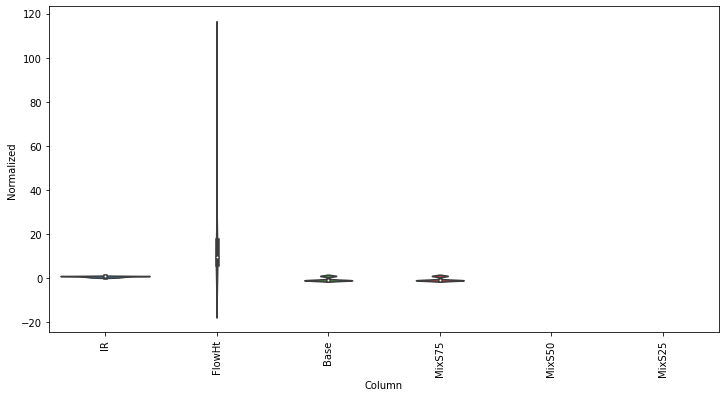

In [22]:
train_mean = train_df.mean()
train_std = train_df.std()
#df_std = (df - train_mean) / train_std
df_mean = df.mean()
df_std = df.std()
df_std_s = (df - train_mean) / train_std
df_std_m = df_std_s.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std_m)
_ = ax.set_xticklabels(df.keys(), rotation=90)


### remove nan after standard normalization
```
#drop feature including NaN
df1 = df_std_s.dropna(axis = 1)
df1.info()

corr_matrix = df1.corr()
corr_matrix["FlowHt"].sort_values(ascending=False)
```

In [23]:
df_pop = df.copy()
IR =  df_pop.pop('IR')

(1.041325, 0.0)

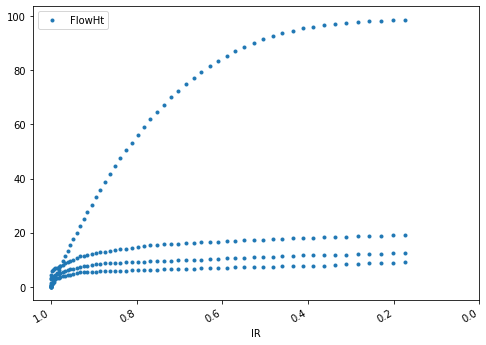

In [24]:
plot_cols = ['FlowHt']
plot_features = df[plot_cols]
plot_features.index = IR
_ = plot_features.plot( linestyle = 'None', marker = '.', subplots=True)
plt.xlim([plt.xlim()[1], 0])

(1.041325, 0.0)

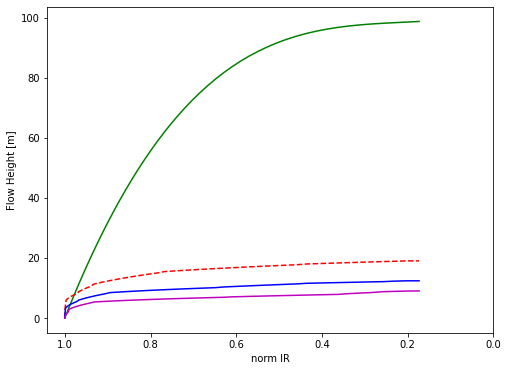

In [25]:
plt.plot(df.iloc[0:58,0], df.iloc[0:58,1], 'g-'
         , df.iloc[58:116,0], df.iloc[58:116,1],'r--'
         ,df.iloc[116:174,0], df.iloc[116:174,1],'b-'
         ,df.iloc[174:232,0], df.iloc[174:232,1], 'm-')
plt.xlabel('norm IR')
plt.ylabel('Flow Height [m]')
#plt.axis('equal')
#plt.axis('square')
plt.xlim([plt.xlim()[1], 0])
#plt.ylim([0,plt.ylim()[1]])
#_ = plt.plot([-100, 100], [-100, 100])

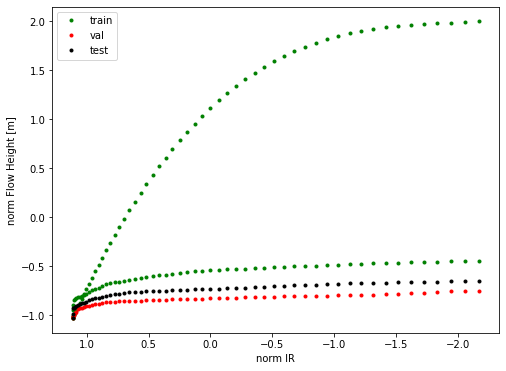

In [26]:
plt.plot(train_df['IR'], train_df['FlowHt'], 'g.', label='train')
plt.plot(         val_df['IR'], val_df['FlowHt'], 'r.', label='val')
plt.plot(          test_df['IR'], test_df['FlowHt'], 'k.', label='test')
plt.xlabel('norm IR')
plt.ylabel('norm Flow Height [m]')
plt.xlim([plt.xlim()[1], plt.xlim()[0]])
plt.ylim([plt.ylim()[0], plt.ylim()[1]])
plt.legend(loc='best')


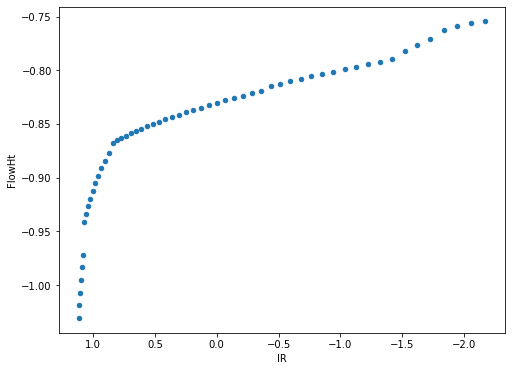

In [27]:
ax = val_df.plot(kind="scatter", x="IR", y="FlowHt")

ax.invert_xaxis()

## 데이터 창 작업
### WindowGrerator Class

In [28]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'
    ])


def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]

  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)
  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])
  return inputs, labels

WindowGenerator.split_window = split_window


def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, #default
#      shuffle=True, #default
      batch_size=16,)
  ds = ds.map(self.split_window)
  return ds

WindowGenerator.make_dataset = make_dataset

def time(self, data) :
    data = np.array(data, dtype=np.float32)
    ds_lab = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=False, #default
#      shuffle=True, #default
      batch_size=16,)
#
#    for batch in ds:
#        labels_1 = batch[:, self.labels_slice, :]
#        labels_t = tf.stack( [labels_1[:, :, 0:2]])
#    labels_t = labels_t[0,:,:,:]
    ds_lab = ds_lab.map(self.split_window_lab)

    return ds_lab

WindowGenerator.time = time

def split_window_lab(self, features):
#  inputs_t = features[:, self.input_slice, :]
  labels_t = features[:, self.labels_slice, :]

  lab = tf.identity(labels_t)
  lab = tf.stack([lab[:, :, 0:2]])
  lab = lab[0,:,:,:]

#  if self.label_columns is not None:
#    labels_t = tf.stack(
#        [labels_t[:, :, self.column_indices[name]] for name in self.label_columns],
#        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
#  inputs_t.set_shape([None, self.input_width, None])
#  labels_t.set_shape([None, self.label_width, None])
  lab.set_shape([None, self.label_width, None])

#  return inputs_t,labels_t, lab
  return lab

WindowGenerator.split_window_lab = split_window_lab


@property
def train(self):
  return self.make_dataset(self.train_df)
#  return self.make_dataset(self.train_df_s)

@property
def val(self):
  return self.make_dataset(self.val_df)
#  return self.make_dataset(self.val_df_s)

@property
def test(self):
  return self.make_dataset(self.test_df)
#  return self.make_dataset(self.test_df_s)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result


WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

@property
def train_time (self):
    return self.time(self.train_df)
@property
def val_time (self):
    return self.time(self.val_df)
@property
def test_time (self):
    return self.time(self.test_df)


WindowGenerator.train_time = train_time
WindowGenerator.val_time = val_time
WindowGenerator.test_time = test_time

In [29]:
wide_window = WindowGenerator(
    input_width=8, label_width=8, shift=1,
    label_columns=['FlowHt'])

wide_window
#print(wide_window)


dataset_test = wide_window.train
for batch in dataset_test :
    inputs, targets = batch
timeset = wide_window.train_time
for batch in timeset :
    lab = batch

### plot : original, one batch example, time indeces plot

In [30]:
n=0
for example_inputs, example_labels in wide_window.train.take(2):
#for example_inputs, example_labels in wide_window.train:
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
#  print(f'Inputs shape (batch, time, features): {example_inputs[31][23][18]}')
#  print(f'Inputs shape (batch, time, features): {example_inputs[0][0:2][:]}')
#  print(f'Inputs shape (batch, time, features): {example_inputs}')
  n+=1

0
Inputs shape (batch, time, features): (16, 8, 6)
Labels shape (batch, time, features): (16, 8, 1)
1
Inputs shape (batch, time, features): (16, 8, 6)
Labels shape (batch, time, features): (16, 8, 1)


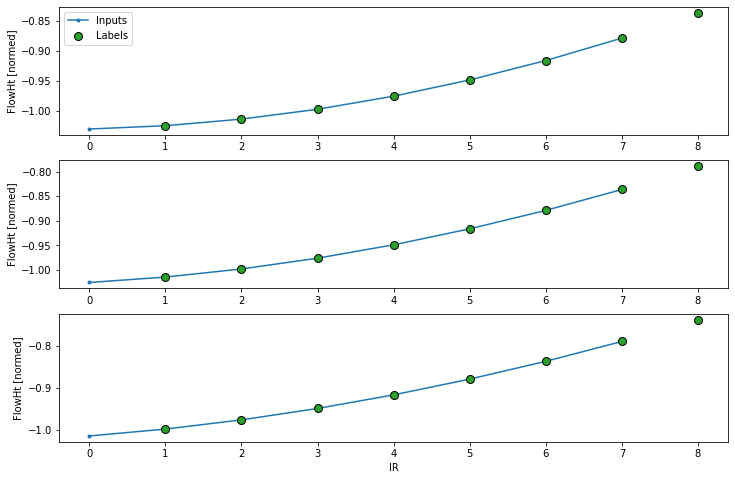

In [31]:
def plot(self, model=None, plot_col='FlowHt', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
#  for n in range(3, 32):
    plt.subplot(3, 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('IR')

WindowGenerator.plot = plot

wide_window.plot()

In [32]:
tf.executing_eagerly()

True

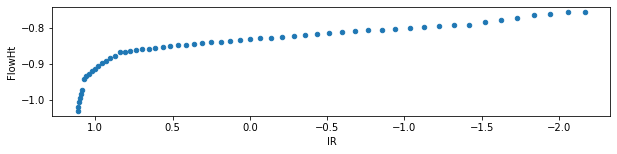

In [33]:
ax = val_df.plot(kind="scatter", x="IR", y="FlowHt", figsize=(10,2))

ax.invert_xaxis()

## plot_4

In [47]:
labset = wide_window.train_time


for i, batch in enumerate(labset) :
   print(i, batch)

0 tf.Tensor(
[[[ 1.1110945  -1.0252376 ]
  [ 1.1071228  -1.0142165 ]
  [ 1.101165   -0.9977417 ]
  [ 1.0932217  -0.9758684 ]
  [ 1.0832922  -0.9486825 ]
  [ 1.071377   -0.9162792 ]
  [ 1.0574759  -0.8787874 ]
  [ 1.041589   -0.836339  ]]

 [[ 1.1071228  -1.0142165 ]
  [ 1.101165   -0.9977417 ]
  [ 1.0932217  -0.9758684 ]
  [ 1.0832922  -0.9486825 ]
  [ 1.071377   -0.9162792 ]
  [ 1.0574759  -0.8787874 ]
  [ 1.041589   -0.836339  ]
  [ 1.0237162  -0.7890998 ]]

 [[ 1.101165   -0.9977417 ]
  [ 1.0932217  -0.9758684 ]
  [ 1.0832922  -0.9486825 ]
  [ 1.071377   -0.9162792 ]
  [ 1.0574759  -0.8787874 ]
  [ 1.041589   -0.836339  ]
  [ 1.0237162  -0.7890998 ]
  [ 1.0038575  -0.7372447 ]]

 [[ 1.0932217  -0.9758684 ]
  [ 1.0832922  -0.9486825 ]
  [ 1.071377   -0.9162792 ]
  [ 1.0574759  -0.8787874 ]
  [ 1.041589   -0.836339  ]
  [ 1.0237162  -0.7890998 ]
  [ 1.0038575  -0.7372447 ]
  [ 0.98201287 -0.680964  ]]

 [[ 1.0832922  -0.9486825 ]
  [ 1.071377   -0.9162792 ]
  [ 1.0574759  -0.8787874 ]

In [35]:
dataset = tf.data.Dataset.from_tensor_slices([1, 2, 3])
dataset = dataset.map(lambda x: x*2)
list(dataset.as_numpy_iterator())

[2, 4, 6]

In [ ]:
def plot_train_batch(self, model=None, plot_col='FlowHt', max_subplots=40):
  font = { 'family': 'serif', 'color' : 'black', 'weight': 'normal', 'size'  :  10}

  dataset = self.train
  labset = self.train_time
  for i, batch in dataset :
        input, labels = batch
        lab = labset.take(i)

  for
  nrows = len(inputs)
          fvsize = nrows * 1.2
          plot_col_index = self.column_indices[plot_col]
          max_n = min(max_subplots, len(inputs))
          fig, ax = plt.subplots(nrows, ncols=1, figsize = (12,fvsize), tight_layout = True)

  for n in range(max_n):
#    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
    ax[n].plot(inputs[n, :, 0], inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    ax[n].text(0.9,0.1, "n = {}".format(n), fontdict =font, ha="center", transform=ax[n].transAxes)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
  #  ax[n].scatter(self.label_indices, labels[n, :, label_col_index],
    ax[n].scatter(lab[n,:, 0], labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if n == 0:
      ax[n].legend()

    ax[n].set_ylabel(f'{plot_col} [normed]')
    ax[n].set_ylim([-1.5, 0.1])
    ax[n].set_xlim([-2.2, 1.12])
    ax[n].invert_xaxis()

  ax[n].set_xlabel('IR')

WindowGenerator.plot_4 = plot_4
#---------------------

In [45]:
from matplotlib import gridspec

def plot_4(self, inputs, labels, lab, model=None, plot_col='FlowHt', max_subplots=40):
  nrows = len(inputs)
  fvsize = nrows * 1.2
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))

  fig, ax = plt.subplots(nrows, ncols=1, figsize = (12,fvsize), tight_layout = True)

  font = { 'family': 'serif', 'color' : 'black', 'weight': 'normal', 'size'  :  10}

  for n in range(max_n):
#    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
    ax[n].plot(inputs[n, :, 0], inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    ax[n].text(0.9,0.1, "n = {}".format(n), fontdict =font, ha="center", transform=ax[n].transAxes)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue
  #  ax[n].scatter(self.label_indices, labels[n, :, label_col_index],
    ax[n].scatter(lab[n,:, 0], labels[n, :, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if n == 0:
      ax[n].legend()

    ax[n].set_ylabel(f'{plot_col} [normed]')
    ax[n].set_ylim([-1.5, 0.1])
    ax[n].set_xlim([-2.2, 1.12])
    ax[n].invert_xaxis()

  ax[n].set_xlabel('IR')

WindowGenerator.plot_4 = plot_4
#---------------------
dataset = wide_window.test
n = 0

timeset = wide_window.train_time

for batch, batchlab in dataset, timeset :
  inputs, targets = batch
  lab = batchlab
  print(f'Inputs shape (batch, time, features): {inputs.shape}')
  print(f'Labels shape (batch, time, features): {targets.shape}')
  wide_window.plot_4(inputs, targets, lab)

n += 1
#  if (n == 6) : break

ValueError: too many values to unpack (expected 2)

### not good : plot_3
```
def plot_3(inputs, labels, lab, n1, plot_col='FlowHt', model=None ):
  nrows = len(inputs)
  fvsize = nrows * 1.2
  plt.figure(figsize=(12, fvsize))

  for n in range(len(inputs)):
    plt.subplot(len(inputs), 1, n+1)
    plt.ylabel(f'{plot_col} [normed]')
    plt.plot(inputs[n, :, 0], inputs[n,:,1],
             label='Inputs', marker='.', zorder=-10)
#    plt.scatter(input_indices+1, labels[n],
    plt.scatter(lab[n, :, 0], labels[n],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(lab[n, :, 0], predictions[n],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)
    font = {
        'family': 'serif',
        'color' : 'green',
        'weight': 'normal',
        'size'  :  12}
#   plt.text(0.05, .85,"number({})".format(n), fontdict =font, fontsize=10)
 #   plt.text(1.1, .8,"n = {}".format(n), fontdict =font)
 #   plt.text(0.05, 0.95,n )
 #   plt.ylim([-1.5, 2.2])
 #   plt.xlim([0.0, 1.2])
    plt.gca().invert_xaxis()
  plt.xlabel('IR')

  print(f'batch num = {n1+1}')

dataset = wide_window.test
n = 0
for batch in dataset :

  inputs, targets, lab = batch
#  plot_features = inputs
  print(f'Inputs shape (batch, time, features): {inputs.shape}')
  print(f'Labels shape (batch, time, features): {targets.shape}')

  plot_3(inputs, targets, lab, n)
  n += 1
#  if (n == 1) : break
fig= plt.figure()
fig.show()
```

plot_cols = ['FlowHt']
plot_features = df[plot_cols]
plot_features.index = IR
_ = plot_features.plot(subplots=True)

## 단일 스텝 모델

In [ ]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['FlowHt'])
single_step_window

### 기준

In [ ]:
class Baseline(tf.keras.Model):
  def __init__(self, label_index=None):
    super().__init__()
    self.label_index = label_index

  def call(self, inputs):
    if self.label_index is None:
      return inputs
    result = inputs[:, :, self.label_index]
    return result[:, :, tf.newaxis]

baseline = Baseline(label_index=column_indices['FlowHt'])

baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds

val_performance = {}

#dataset_val = single_step_window.val

for inputs, labels, lab in single_step_window.val.take(10):

#for inputs, labels, lab in tfds.as_numpy(single_step_window.val):

#  print(type(inputs), type(labels), label)

    val_performance['Baseline'] = baseline.evaluate(inputs, labels)
    val_performance['Baseline'] =val_performance['Baseline']  +val_performance['Baseline']

keys = 'Baseline'
fig, ax = plt.subplots(figsize=(16, 4))
for keys in val_performance.keys() :
    i = 0
    for x in val_performance[keys] :
        ax.plot(i, x, 'o')
        i += 1

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(single_step_window.val, verbose=1)
#performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)


In [ ]:
wide_window = WindowGenerator(
    input_width=8, label_width=8, shift=1,
    label_columns=['FlowHt'])

wide_window


wide_window.plot(baseline)

val_performance['Baseline_wide'] = baseline.evaluate(wide_window.val)
performance['Baseline_wide'] = baseline.evaluate(wide_window.test, verbose=0)

print(f'val_performance :{val_performance}')
print(f'test_performance :{performance}')

In [ ]:
from matplotlib import gridspec

def plot_5(self, inputs, labels, IR, n1, model=None, plot_col='FlowHt', max_subplots=40):
  nrows = len(inputs)
  fvsize = nrows * 3
  font = {'family': 'serif','color' : 'black','weight': 'normal',
        'size' :  20}
  plt.figure(figsize=(12, fvsize))
#
  plot_col_index = self.column_indices[plot_col]

  max_n = min(max_subplots, len(inputs))

  fig, ax = plt.subplots(nrows, ncols=1, figsize = (12,fvsize), tight_layout = True)

  for n in range(max_n):
    input_indices = IR[n+n1*16 : n+n1*16 + self.total_window_size]

#    plt.plot(self.input_indices, inputs[n, :, plot_col_index],
    ax[n].plot(input_indices[:-1], inputs[n, :, plot_col_index],
             label='Inputs', marker='.', zorder=-10)
    ax[n].text(0.9,0.1, "n = {}".format(n), fontdict =font, ha="center", transform=ax[n].transAxes)

#    plt.scatter(input_indices+1, labels[n],
    ax[n].scatter(input_indices[1:],  labels[n],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    ax2.scatter(input_indices[1:],  labels[n], marker='x',
                edgecolors='k', label='Labels', c='#2ca02c', s=64)

    if model is not None:
      predictions = model(inputs)
      ax[n].scatter(input_indices[1:], predictions[n],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

      #------------------------------------------------
      inputs1 = np.array(inputs).copy()
#    print(inputs1[:,1, 1])
      inputs1[:,1, 1]=0
#    print(inputs1[:,1])
      predictions = baseline(inputs1)
      #plt.scatter(inputs1[n+1,:, 0], predictions[n],
      #            marker='x', label='Predictions',
      #            c='#ff7f0e', s=64)
    #-----------------------------------------------------------------
      ax2.scatter(input_indices[1:], predictions[n],
                  marker='o', label='Predictions')

    if n == 0:
      ax[n].legend()

    ax[n].set_ylabel(f'{plot_col} [normed]')
    ax[n].invert_xaxis()

  ax[n].set_xlabel('IR')

WindowGenerator.plot_5 = plot_5

#------------------------------------------
dataset = wide_window.test
n = 0

fig, ax2 = plt.subplots()



for batch in dataset :

  inputs, targets = batch
  plot_features = inputs
  print(f'Inputs shape (batch, time, features): {inputs.shape}')
  print(f'Labels shape (batch, time, features): {targets.shape}')


  wide_window.plot_5(inputs, targets, IR, n, baseline)
  n += 1
#  if (n == 4) : break


ax2.invert_xaxis()
ax2.legend()

In [ ]:
dataset = wide_window.test

batch_size = 16
n = 0
for batch in dataset :
    inputs, targets = batch
    inputs1 = np.array(inputs).copy()
    n2 = len(inputs)
#    print(inputs1[:,1, 1])
    inputs1[:,1, 1]=0
#    print(inputs1[:,1])

    predictions = baseline(inputs1)

    nrows = len(inputs)

    for i in range(nrows-1) :
        plt.scatter(inputs1[i,:, 0], predictions[i],
                  marker='o', label='Predictions')
        plt.scatter(inputs[i, :, 0],  targets[i],
                edgecolors='k', label='Labels', c='#2ca02c' )

 #       plt.legend()
    n += 1
    if (n == 6) : break
plt.gca().invert_xaxis()

In [ ]:
big_window = WindowGenerator(
    input_width=57, label_width=57, shift=1,
    label_columns=['FlowHt'])

big_window

In [ ]:
dataset = big_window.test
n = 1
for batch in dataset :
  inputs, targets = batch
  ww = np.size(inputs, 1)
  print(f'Inputs shape (batch, time, features): {inputs.shape}')
  print(f'Labels shape (batch, time, features): {targets.shape}')
  plot_3(inputs, targets, ww, n, model=baseline)
  n += 1

### 선형 모델

In [ ]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [ ]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

In [ ]:
MAX_EPOCHS =20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(),
                metrics=[tf.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val)
#                      ,callbacks=[early_stopping])
  return history

In [ ]:
hist = compile_and_fit(linear, single_step_window)
#IPython.display.clear_output()
single_step_window.plot(linear)

In [ ]:
val_performance['Linear'] = linear.evaluate(single_step_window.val)
performance['Linear'] = linear.evaluate(single_step_window.test)

val_performance['Linear'] = linear.evaluate(single_step_window.train)

In [ ]:
# 5. 모델 학습 과정 표시하기
%matplotlib inline
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots()

acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')

acc_ax.plot(hist.history['mean_absolute_error'], 'b', label='train MAE')
acc_ax.plot(hist.history['val_mean_absolute_error'], 'g', label='val MAE')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('mean_absolute_error')

#loss_ax.legend(loc='upper left')
#acc_ax.legend(loc='lower left')
loss_ax.legend(loc='center')
acc_ax.legend(loc='lower center')

plt.show()

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(linear, wide_window)

wide_window.plot(linear)

In [ ]:
dataset = wide_window.train
n = 1
for batch in dataset :
  inputs, targets = batch
  ww = np.size(inputs, 1)
  print(f'Inputs shape (batch, time, features): {inputs.shape}')
  print(f'Labels shape (batch, time, features): {targets.shape}')
  plot_3(inputs, targets, ww, n, model=linear)
  n += 1

In [ ]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

### 밀집

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, wide_window)

val_performance['Dense'] = dense.evaluate(wide_window.val)
performance['Dense'] = dense.evaluate(wide_window.test)
#performance['Dense'] = dense.evaluate(wide_window.test, verbose=0)

### 다중 스텝 밀집

In [ ]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['FlowHt'])

conv_window

In [ ]:
conv_window.plot()
plt.title("Given 3h as input, predict 1h into the future.")

`layers.Flatten`을 모델의 첫 번째 레이어로 추가하여 다중 입력 스텝 창에서 `dense` 모델을 훈련할 수 있습니다.

In [ ]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=16, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [ ]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

In [ ]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0)

In [ ]:
conv_window.plot(multi_step_dense)


이 접근법의 주된 단점은 결과적인 모델이 정확히 이 형상의 입력 창에서만 실행될 수 있다는 것입니다. 

In [ ]:
print('Input shape:', wide_window.example[0].shape)
try:
  print('Output shape:', multi_step_dense(wide_window.example[0]).shape)
except Exception as e:
  print(f'\n{type(e).__name__}:{e}')

다음 섹션의 컨볼루셔널 모델은 이 문제를 해결합니다.

### 컨볼루션 신경망

컨볼루션 레이어(`layers.Conv1D`)도 각 예측에 대한 입력으로 여러 타임스텝을 사용합니다.

다음은 컨볼루션으로 다시 작성한 `multi_step_dense`와 **동일한** 모델입니다.

다음 변경 사항에 주목하세요.

- `layers.Flatten`과 첫 번째 `layers.Dense`는 `layers.Conv1D`로 대체됩니다.
- 컨볼루션이 출력에서 시간 축을 유지하므로 `layers.Reshape`는 이 더 이상 필요하지 않습니다.

In [ ]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

예제 배치에서 실행하여 모델이 예상된 형상으로 출력을 생성하는지 확인합니다.

In [ ]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

In [ ]:
n=1
for example_inputs, example_labels in conv_window.train.take(30): #1534, 6
#for example_inputs, example_labels in single_step_window.train.take(3):
#for example_inputs, example_labels in wide_window.train.take(2000): #1533 15
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  n += 1


`conv_window`에서 훈련하고 평가하면 `multi_step_dense` 모델과 유사한 성능을 제공해야 합니다.

In [ ]:
history = compile_and_fit(conv_model, conv_window)

#IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val)
#performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0)
performance['Conv'] = conv_model.evaluate(conv_window.test)

이 `conv_model`과 `multi_step_dense` 모델의 차이점은 `conv_model`은 모든 길이의 입력에서 실행될 수 있다는 것입니다. 컨볼루셔널 레이어는 입력의 슬라이딩 윈도우에 적용됩니다.

![Executing a convolutional model on a sequence](https://www.tensorflow.org/tutorials/structured_data/images/wide_conv_window.png)

더 넓은 입력에서 실행하면 더 넓은 출력이 생성됩니다.

In [ ]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

출력은 입력보다 짧습니다. 훈련 또는 플롯 작업을 수행하려면 레이블과 예상의 길이가 동일해야 합니다. 따라서 레이블과 예측 길이가 일치하도록 몇 개의 추가 입력 타임스텝으로 넓은 창을 생성하는 `WindowGenerator`를 빌드합니다. 

In [ ]:
LABEL_WIDTH = 16
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['FlowHt'])

wide_conv_window

In [ ]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

In [ ]:
n=1
for example_inputs, example_labels in wide_conv_window.train.take(2000): #1534, 6
#for example_inputs, example_labels in single_step_window.train.take(3):
#for example_inputs, example_labels in wide_window.train.take(2000): #1533 15
  print(n)
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')
  n += 1

이제 더 넓은 창에 모델의 예측값을 플롯할 수 있습니다. 첫 번째 예측 전 3개의 입력 타임스텝에 주목하세요. 여기서 모든 예측은 이전 3개의 타임스텝에 기초합니다.

In [ ]:
wide_conv_window.plot(conv_model)

### 순환 신경망

Recurrent Neural Network(RNN)는 시계열 데이터에 적합한 신경망 유형입니다. RNN은 시계열을 단계별로 처리하여 타임스텝 사이에서 내부 상태를 유지합니다.

자세한 내용은 [텍스트 생성 튜토리얼](https://www.tensorflow.org/tutorials/text/text_generation) 또는 [RNN 가이드](https://www.tensorflow.org/guide/keras/rnn)를 읽어보세요.

이 튜토리얼에서는 [Long Short Term Memory](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/LSTM)(LSTM)이라는 RNN 레이어를 사용합니다.

모든 keras RNN 레이어에 대한 중요한 생성자 인수는 `return_sequences` 인수입니다. 이 설정은 다음 두 가지 방법 중 하나로 레이어를 구성할 수 있습니다.

1. 기본값인 `False`인 경우 레이어는 최종 타임스텝의 출력만 반환하여 단일 예측을 수행하기 전에 모델이 내부 상태를 준비할 시간을 줍니다.

![An lstm warming up and making a single prediction](https://www.tensorflow.org/tutorials/structured_data/images/lstm_1_window.png)

1. `True`이면 레이어가 각 입력에 대한 출력을 반환합니다. 다음과 같은 경우에 유용합니다.

- RNN 레이어 쌓기
- 여러 타임스텝에서 동시에 모델 훈련

![An lstm making a prediction after every timestep](https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

`return_sequences=True`이면 모델을 한 번에 24시간 분량 데이터에 대해 훈련할 수 있습니다.

참고: 이 경우에는 모델 성능의 관점에서 기대할 것이 없습니다. 첫 번째 타임스텝에서 모델이 이전 스텝에 액세스할 수 없으므로 이전에 표시한 단순한 `linear` 및 `dense` 모델보다 더 나을 것이 없기 때문입니다.

In [ ]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

In [ ]:
history = compile_and_fit(lstm_model, wide_window)

#IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0)

In [ ]:
wide_window.plot(lstm_model)

In [ ]:
dataset = wide_window.train
n = 1
for batch in dataset :
  inputs, targets = batch
  ww = np.size(inputs, 1)
  print(f'Inputs shape (batch, time, features): {inputs.shape}')
  print(f'Labels shape (batch, time, features): {targets.shape}')
  plot_3(inputs, targets, ww, n, model=linear)
  n += 1

### 성능

이 데이터세트를 사용하면 일반적으로 각 모델의 성능이 이전 모델보다 약간 더 좋습니다.

In [ ]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [FlowHt, normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')

### 다중 출력 모델

지금까지 모델은 모두 단일 타임스텝에 대해 단일 출력 특성 `T (degC)`를 예측했습니다.

이러한 모든 모델은 간단히 출력 레이어의 단위 수를 변경하고 `labels`에 모든 특성을 포함하도록 훈련 창을 조정하여 여러 특성을 예측하도록 변환할 수 있습니다.


In [ ]:
single_step_window = WindowGenerator(
    # `WindowGenerator` returns all features as labels if you 
    # don't set the `label_columns` argument.
    input_width=1, label_width=1, shift=1)

wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1)

for example_inputs, example_labels in wide_window.train.take(1):
  print(f'Inputs shape (batch, time, features): {example_inputs.shape}')
  print(f'Labels shape (batch, time, features): {example_labels.shape}')

레이블의 `features` 축은 이제 1이 아닌 입력과 동일한 깊이를 갖습니다.

#### 기준

여기서는 동일한 기준 모델을 사용할 수 있지만 이번에는 특정 `label_index`를 선택하는 대신 모든 특성을 반복합니다.

In [ ]:
baseline = Baseline()
baseline.compile(loss=tf.losses.MeanSquaredError(),
                 metrics=[tf.metrics.MeanAbsoluteError()])

In [ ]:
val_performance = {}
performance = {}
val_performance['Baseline'] = baseline.evaluate(wide_window.val)
performance['Baseline'] = baseline.evaluate(wide_window.test)

#### 밀집

In [ ]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=num_features)
])

In [ ]:
history = compile_and_fit(dense, single_step_window)

IPython.display.clear_output()
val_performance['Dense'] = dense.evaluate(single_step_window.val)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0)

#### RNN


In [ ]:
%%time
wide_window = WindowGenerator(
    input_width=8, label_width=8, shift=1)

lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(16, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=num_features)
])

history = compile_and_fit(lstm_model, wide_window)

IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate( wide_window.val)
performance['LSTM'] = lstm_model.evaluate( wide_window.test, verbose=0)

print()

<a id="residual"></a>

#### 고급: 잔여 연결

이전의 `Baseline` 모델은 시퀀스가 타임스텝 사이에서 크게 변하지 않는다는 사실을 이용했습니다. 지금까지 이 튜토리얼에서 훈련한 모든 모델은 무작위로 초기화된 다음, 출력이 이전 타임스텝에서 약간 변경된다는 사실을 학습해야 했습니다.

신중한 초기화로 이 문제를 해결할 수 있지만 모델 구조로 빌드하는 것이 더 간단합니다.

시계열 분석에서는 다음 값을 예측하는 대신 다음 타임스텝에서 값이 어떻게 달라지는 지를 예측하는 모델을 빌드하는 것이 일반적입니다. 마찬가지로 딥러닝에서 "잔여 네트워크(Residual networks)" 또는 "ResNets"는 각 레이어가 모델의 누적 결과에 추가되는 아키텍처를 나타냅니다.

이것은 변화가 작아야 한다는 사실을 이용하는 방법입니다.

![A model with a residual connection](https://www.tensorflow.org/tutorials/structured_data/images/residual.png)

기본적으로, `Baseline`과 일치하도록 모델을 초기화합니다. 그러면 이 작업에서 약간 더 나은 성능으로 모델이 더 빨리 수렴하는 데 도움이 됩니다.

이 접근 방식은 이 튜토리얼에서 설명하는 모든 모델과 연계하여 사용할 수 있습니다.

여기서는 LSTM 모델에 적용합니다. `tf.initializers.zeros`를 사용하여 초기 예측하는 변경이 작고 잔류 연결을 억제하지 않도록 한다는 점에 주목하세요. `zeros`가 마지막 레이어에서만 사용되기 때문에 여기에서 그래디언트에 대한 대칭성이 깨질 우려는 없습니다.

In [ ]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each timestep is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [ ]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(16, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small
        # So initialize the output layer with zeros
        kernel_initializer=tf.initializers.zeros)
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0)
print()

#### 성능

다음은 이러한 다중 출력 모델의 전반적인 성능입니다.

In [ ]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()

In [ ]:
for name, value in performance.items():
  print(f'{name:15s}: {value[1]:0.4f}')

위의 성능은 모든 모델 출력에 대한 평균입니다.

## 다중 스텝 모델

이전 섹션의 단일 출력 및 다중 출력 모델은 모두 미래 1시간의 **단일 타임스텝 예측**을 수행했습니다.

이 섹션에서는 이러한 모델을 확장하여 **다중 타임스텝 예측**을 수행하는 방법을 살펴봅니다.

다중 스텝 예측에서 모델은 일정 범위의 미래 값을 예측하는 방법을 학습해야 합니다. 따라서 한 미래 시점만 예측하는 단일 스텝 모델과 달리 다중 스텝 모델은 미래 값의 시퀀스를 예측합니다.

대략적으로 두 가지 접근 방식이 있습니다.

1. 전체 시계열이 한 번에 예측되는 싱글샷 예측
2. 모델이 단일 스텝 예측만 수행하고 출력이 입력으로 피드백되는 자기 회귀적 예측

이 섹션에서는 모든 모델이 **모든 출력 타임스텝에 걸쳐 모든 특성**을 예측합니다.


다중 스텝 모델의 경우, 훈련 데이터는 다시 시간별 샘플로 구성됩니다. 그러나 여기에서 모델은 과거의 24시간을 고려하여 미래 24시간을 예측하는 방법을 학습합니다.

다음은 데이터세트로부터 이러한 조각을 생성하는 `Window` 객체입니다.

In [ ]:
OUT_STEPS = 16
multi_window = WindowGenerator(input_width=16,
                               label_width=OUT_STEPS,
                               shift=OUT_STEPS)

multi_window.plot()
multi_window

### 기준

이 작업의 간단한 기준은 필요한 출력 타임스텝 수에 대해 마지막 입력 타임스텝을 반복하는 것입니다.

![Repeat the last input, for each output step](https://www.tensorflow.org/tutorials/structured_data/images/multistep_last.png)

In [ ]:
class MultiStepLastBaseline(tf.keras.Model):
  def call(self, inputs):
    return tf.tile(inputs[:, -1:, :], [1, OUT_STEPS, 1])

last_baseline = MultiStepLastBaseline()
last_baseline.compile(loss=tf.losses.MeanSquaredError(),
                      metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance = {}
multi_performance = {}

multi_val_performance['Last'] = last_baseline.evaluate(multi_window.val)
multi_performance['Last'] = last_baseline.evaluate(multi_window.val, verbose=0)
multi_window.plot(last_baseline)

이 작업은 24시간이 주어졌을 때 24시간을 예측하는 것이므로 또 다른 간단한 접근 방법은 내일도 비슷하다는 가정 하에 전날을 반복하는 것입니다.

![Repeat the previous day](https://www.tensorflow.org/tutorials/structured_data/images/multistep_repeat.png)

In [ ]:
class RepeatBaseline(tf.keras.Model):
  def call(self, inputs):
    return inputs

repeat_baseline = RepeatBaseline()
repeat_baseline.compile(loss=tf.losses.MeanSquaredError(),
                        metrics=[tf.metrics.MeanAbsoluteError()])

multi_val_performance['Repeat'] = repeat_baseline.evaluate(multi_window.val)
multi_performance['Repeat'] = repeat_baseline.evaluate(multi_window.test, verbose=0)
multi_window.plot(repeat_baseline)

### 싱글샷 모델

이 문제에 대한 한 가지 높은 수준의 접근 방법은 모델이 한 번에 전체 시퀀스 예측을 수행하는 "싱글샷" 모델을 사용하는 것입니다.

이 모델은 `OUT_STEPS*features` 출력 단위를 이용해 `layers.Dense`로 효율적으로 구현할 수 있습니다. 이 모델은 이 출력의 형상을 필요한 `(OUTPUT_STEPS, features)`로 바꾸기만 하면 됩니다.

#### 선형

마지막 입력 타임스텝을 기반으로 하는 단순한 선형 모델은 기준 모델보다 성능이 더 좋지만 강력하지 못합니다. 이 모델은 선형 프로젝션을 이용해 단일 입력 타임스텝으로부터 `OUTPUT_STEPS` 타임스텝을 예측해야 합니다. 주로 하루 중 시간과 연중 시간을 기반으로 하는 행동의 저차원 조각만 캡처할 수 있습니다.

![Predct all timesteps from the last time-step](https://www.tensorflow.org/tutorials/structured_data/images/multistep_dense.png)

In [ ]:
multi_linear_model = tf.keras.Sequential([
    # Take the last time-step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_linear_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Linear'] = multi_linear_model.evaluate(multi_window.val)
multi_performance['Linear'] = multi_linear_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_linear_model)

In [ ]:
XX = [0 ,1 ,2,3,4,5,6,7]
XX[-1:]
(lambda xy : XX[-1] ) (XX)

#### 밀집

입력과 출력 사이에 `layers.Dense`를 추가하면 선현 모델이 더 강력해지지만 여전히 단일 입력에 기반합니다.

In [ ]:
multi_dense_model = tf.keras.Sequential([
    # Take the last time step.
    # Shape [batch, time, features] => [batch, 1, features]
    tf.keras.layers.Lambda(lambda x: x[:, -1:, :]),
    # Shape => [batch, 1, dense_units]
    tf.keras.layers.Dense(512, activation='relu'),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_dense_model, multi_window)

IPython.display.clear_output()
multi_val_performance['Dense'] = multi_dense_model.evaluate(multi_window.val)
multi_performance['Dense'] = multi_dense_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_dense_model)

#### CNN

컨볼루션 모델은 고정 너비 기록을 기반으로 예측을 수행하므로 시간에 따라 상황이 어떻게 변하는지 볼 수 있어 밀집 모델보다 성능을 높일 수 있습니다.

![A convolutional model sees how things change over time](https://www.tensorflow.org/tutorials/structured_data/images/multistep_conv.png)

In [ ]:
CONV_WIDTH = 3
multi_conv_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, CONV_WIDTH, features]
    tf.keras.layers.Lambda(lambda x: x[:, -CONV_WIDTH:, :]),
    # Shape => [batch, 1, conv_units]
    tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(CONV_WIDTH)),
    # Shape => [batch, 1,  out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_conv_model, multi_window)

IPython.display.clear_output()

multi_val_performance['Conv'] = multi_conv_model.evaluate(multi_window.val)
multi_performance['Conv'] = multi_conv_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_conv_model)

#### RNN

반복 모델은 모델이 수행하는 예측과 관련이 있는 경우 긴 입력 기록을 사용하는 방법을 학습할 수 있습니다. 여기서 모델은 다음 24시간에 대한 단일 예측을 수행하기 전에 24시간 동안 내부 상태를 축적합니다.

이 싱글샷 형식에서 LSTM은 마지막 타임스텝에서만 출력을 생성하면 되므로 `return_sequences=False`를 설정합니다.

![The lstm accumulates state over the input window, and makes a single prediction for the next 24h](https://www.tensorflow.org/tutorials/structured_data/images/multistep_lstm.png)


In [ ]:
multi_lstm_model = tf.keras.Sequential([
    # Shape [batch, time, features] => [batch, lstm_units]
    # Adding more `lstm_units` just overfits more quickly.
    tf.keras.layers.LSTM(32, return_sequences=False),
    # Shape => [batch, out_steps*features]
    tf.keras.layers.Dense(OUT_STEPS*num_features,
                          kernel_initializer=tf.initializers.zeros),
    # Shape => [batch, out_steps, features]
    tf.keras.layers.Reshape([OUT_STEPS, num_features])
])

history = compile_and_fit(multi_lstm_model, multi_window)

IPython.display.clear_output()

multi_val_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.val)
multi_performance['LSTM'] = multi_lstm_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(multi_lstm_model)

### 고급: 자기 회귀 모델

위의 모델은 모두 한 번에 전체 출력 시퀀스를 예측합니다.

경우에 따라 모델이 이 예측을 여러 타임스텝으로 분해하는 것이 도움이 될 수 있습니다. 그러면 이전의 [RNN(Recurrent Neural Networks)을 이용한 시퀀스 생성](https://arxiv.org/abs/1308.0850)에서와 같이 각 모델의 출력을 각 스텝에서 자체 피드백할 수 있어 이전 예측을 조건부로 예측을 수행할 수 있습니다.

이 형태의 모델이 갖는 한 가지 분명한 장점은 다양한 길이의 출력을 생성하도록 설정할 수 있다는 것입니다.

이 튜토리얼의 전반부에서 훈련한 단일 스텝 다중 출력 모델 중 하나를 가져와 자기 회귀 피드백 루프에서 실행할 수 있지만 여기서는 이를 수행하도록 명시적으로 훈련된 모델을 빌드하는 데 중점을 둘 것입니다.

![Feedback a model's output to its input](https://www.tensorflow.org/tutorials/structured_data/images/multistep_autoregressive.png)


#### RNN

이 튜토리얼에서는 자기 회귀 RNN 모델만 빌드하지만 이 패턴은 단일 타임스텝을 출력하도록 설계된 모든 모델에 적용할 수 있습니다.

이 모델은 단일 스텝 `LSTM` 모델과 기본 형태가 동일하여 `LSTM` 다음에 `LSTM` 출력을 모델 예측으로 변환하는 `layers.Dense`가 이어집니다.

`layers.LSTM`은 상태와 시퀀스 결과를 자동으로 관리하는 더 높은 수준의 `layers.RNN`에서 래핑된 `layers.LSTMCell`입니다(자세한 내용은 [Keras RNN](https://www.tensorflow.org/guide/keras/rnn) 참조).

이 경우 모델은 각 스텝에 대한 입력을 수동으로 관리해야 하므로 더 낮은 수준의 단일 타임스텝 인터페이스에 대해 `layers.LSTMCell`를 직접 사용합니다.

In [ ]:
class FeedBack(tf.keras.Model):
  def __init__(self, units, out_steps):
    super().__init__()
    self.out_steps = out_steps
    self.units = units
    self.lstm_cell = tf.keras.layers.LSTMCell(units)
    # Also wrap the LSTMCell in an RNN to simplify the `warmup` method.
    self.lstm_rnn = tf.keras.layers.RNN(self.lstm_cell, return_state=True)
    self.dense = tf.keras.layers.Dense(num_features)

In [ ]:
feedback_model = FeedBack(units=32, out_steps=OUT_STEPS)

이 모델에 필요한 첫 번째 메서드는 입력을 기반으로 내부 상태를 초기화하는 `warmup` 메서드입니다. 일단 훈련되면 이 상태는 입력 기록의 관련 부분을 캡처합니다. 이는 앞서 알아본 단일 스텝 `LSTM` 모델과 동일합니다.

In [ ]:
def warmup(self, inputs):
  # inputs.shape => (batch, time, features)
  # x.shape => (batch, lstm_units)
  x, *state = self.lstm_rnn(inputs)

  # predictions.shape => (batch, features)
  prediction = self.dense(x)
  return prediction, state

FeedBack.warmup = warmup

이 메서드는 단일 타임스텝 예측과 LSTM의 내부 상태를 반환합니다.

In [ ]:
prediction, state = feedback_model.warmup(multi_window.example[0])
prediction.shape

`RNN`의 상태 및 초기 예측을 사용하여 이제 이전의 각 스텝에서 수행한 예측을 입력으로 제공하여 모델을 계속 반복할 수 있습니다.

출력 예측을 수집하는 가장 간단한 방법은 Python 목록을 사용하고 루프 후에 `tf.stack`을 사용하는 것입니다.

참고: 이와 같이 Python 목록을 쌓는 것은 훈련을 위해 `Model.compile(..., run_eagerly=True)`를 사용하거나 고정 길이의 출력을 통해 즉시 실행하는 경우에만 효과가 있습니다. 동적 출력 길이의 경우 Python 목록 대신 `tf.TensorArray`를 사용하고 Python `range` 대신 `tf.range`를 사용해야 합니다.

In [ ]:
def call(self, inputs, training=None):
  # Use a TensorArray to capture dynamically unrolled outputs.
  predictions = []
  # Initialize the lstm state
  prediction, state = self.warmup(inputs)

  # Insert the first prediction
  predictions.append(prediction)

  # Run the rest of the prediction steps
  for n in range(1, self.out_steps):
    # Use the last prediction as input.
    x = prediction
    # Execute one lstm step.
    x, state = self.lstm_cell(x, states=state,
                              training=training)
    # Convert the lstm output to a prediction.
    prediction = self.dense(x)
    # Add the prediction to the output
    predictions.append(prediction)

  # predictions.shape => (time, batch, features)
  predictions = tf.stack(predictions)
  # predictions.shape => (batch, time, features)
  predictions = tf.transpose(predictions, [1, 0, 2])
  return predictions

FeedBack.call = call

예제 입력에서 이 모델을 테스트 실행합니다.

In [ ]:
print('Output shape (batch, time, features): ', feedback_model(multi_window.example[0]).shape)

이제 모델을 훈련합니다.

In [ ]:
history = compile_and_fit(feedback_model, multi_window)

IPython.display.clear_output()

multi_val_performance['AR LSTM'] = feedback_model.evaluate(multi_window.val)
multi_performance['AR LSTM'] = feedback_model.evaluate(multi_window.test, verbose=0)
multi_window.plot(feedback_model)

### 성능

이 문제에 대해 모델 복잡성이 증가함에 따라 분명히 이득이 감소합니다.

In [ ]:
x = np.arange(len(multi_performance))
width = 0.3


metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in multi_val_performance.values()]
test_mae = [v[metric_index] for v in multi_performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=multi_performance.keys(),
           rotation=45)
plt.ylabel(f'MAE (average over all times and outputs)')
_ = plt.legend()

이 튜토리얼의 전반부에서 소개한 다중 출력 모델에 대한 메트릭은 모든 출력 특성에 평균화된 성능을 보여줍니다. 이러한 성능은 유사하지만 출력 타임스텝에서도 평균화됩니다. 

In [ ]:
for name, value in multi_performance.items():
  print(f'{name:8s}: {value[1]:0.4f}')

밀집 모델에서 컨볼루션 및 반복 모델로 이동하여 얻은 이득은 몇 퍼센트(있다고 하더라도)에 불과하며 자기 회귀 모델의 성능은 분명히 더 나빴습니다. 따라서 이러한 더 복잡한 접근 방법은 **이** 문제에서는 가치가 없을 수도 있지만 시도해 보기 전에는 알 수 있는 방법이 없었으며 이러한 모델은 **다른 특정** 문제에 도움이 될 수 있습니다.

## 다음 단계

이 튜토리얼에서는 TensorFlow를 사용한 시계열 예측에 대해 간단히 소개했습니다.

- 자세한 내용은 다음을 참조하세요.
    - [Scikit-Learn, Keras 및 TensorFlow를 이용한 머시러닝 실무](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)(2차 개정 버전), 챕터 15
    - [Python을 이용한 딥러닝](https://www.manning.com/books/deep-learning-with-python) 챕터 6
    - [Udacity의 딥러닝 TensorFlow 개론](https://www.udacity.com/course/intro-to-tensorflow-for-deep-learning--ud187) 레슨 8 및 [연습 노트북](https://github.com/tensorflow/examples/tree/master/courses/udacity_intro_to_tensorflow_for_deep_learning)
- 또한 TensorFlow에서 [기존의 시계열 모델](https://otexts.com/fpp2/index.html)은 모두 구현할 수 있다는 점을 기억하세요. 이 튜토리얼에서는 TensdorFlow의 내장 기능에 초점을 맞추었습니다.